In [10]:
from pathlib import Path
import datetime as dt
import random as rd
import matplotlib.pyplot as plt
import numpy as np
import pdb

from scipy.interpolate import interp1d
from scipy.optimize import basinhopping

import astropy.units as u

from pyipn import copy_template, Universe
from pyipn.detector import Detector
from pyipn.grb import GRB
from pyipn.geometry import Pointing
from pyipn.io.orbits.tle import position_skyfield
import pyipn.cc

In [62]:
tle_G = 'GLAST2018-01-01 00:00:00--2018-12-31 00:00:00_tle.txt'
tle_I = 'INTEGRAL2018-01-01 00:00:00--2018-12-31 00:00:00_tle.txt'
date = dt.datetime(2018, 5, 1)

p = Pointing(rd.random()*360, (rd.random()-0.5)*180)
integral = Detector.from_GCRS(position_skyfield(date, tle_I),
                              p,
                              'INTEGRAL')
glast = Detector.from_GCRS(position_skyfield(date, tle_G),
                           p,
                           'GLAST')

grb = GRB(80., -30., 100. * u.Mpc, 1000., 1., 1.)

[0.37835197 0.        ]


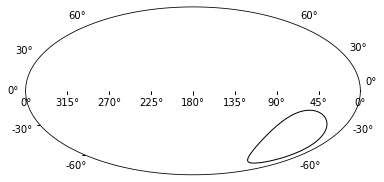

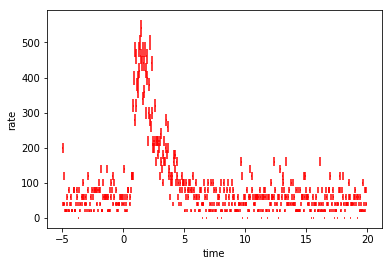

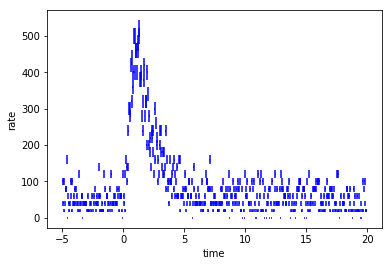

In [63]:
uni = Universe(grb)

uni.register_detector(integral)
uni.register_detector(glast)

uni.explode_grb(tstart=-5,tstop=20)
print(uni._T0)
uni.plot_annulus('INTEGRAL', 'GLAST')

uni.light_curves['INTEGRAL'].display(-5,20,.05,color='red')
uni.light_curves['GLAST'].display(-5,20,.05,color='blue')

xyzI=integral.location.get_cartesian_coord().xyz.value

xyzG=glast.location.get_cartesian_coord().xyz.value

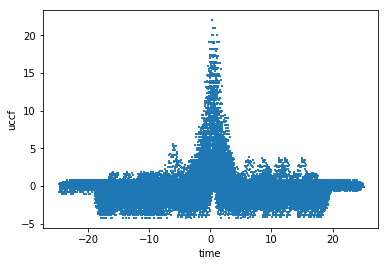

<Figure size 1800x1200 with 0 Axes>

In [64]:
delta_t=0.05
tstart=-5
tstop=20
rate1, edges1 = uni.light_curves['INTEGRAL'].get_binned_light_curve(tstart,tstop,delta_t)
rate2, edges2 = uni.light_curves['GLAST'].get_binned_light_curve(tstart,tstop,delta_t)
lc1_x = edges1[:-1]
lc1_y = rate1
lc2_x = edges2[:-1]
lc2_y = rate2

uccf, lags = pyipn.cc.uccf(lc2_x, lc2_y, lc1_x, lc1_y)

plt.scatter(lags, uccf, marker=',', s=1)
plt.xlabel('time')
plt.ylabel('uccf')
plt.figure(dpi=300)
plt.show()

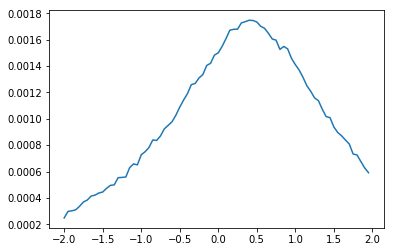

0.40000000000000213


In [65]:
minimum = -2.
maximum = 2.
timediff = .05

bins, dcf = pyipn.cc.dcf(uccf, lags, start=minimum, stop=maximum, step=timediff)

plt.plot(bins, dcf)
plt.show()

print(bins[np.argmax(dcf)])

0.4489795918367343


Text(0, 0.5, 'y data')

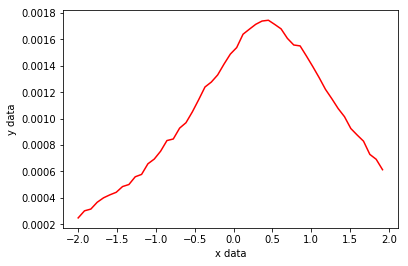

In [66]:
f = interp1d(bins, dcf, kind='cubic', bounds_error=False)

xfit = np.linspace(minimum, maximum)

print(xfit[np.nanargmax(f(xfit))])

plt.plot(xfit, f(xfit),'r-')
plt.xlabel('x data')
plt.ylabel('y data')